The only purpose of this notebook is to generate a submission.

In [1]:
LOCAL = True
data_fpath = '../data/raw/' if LOCAL else '/kaggle/input/protein-localization/'
data_eng_fpath = '../data/intermediate/' if LOCAL else ''

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import data_tools

In [3]:
from datetime import datetime
import pickle

import lightgbm as lgb
import pandas as pd
import numpy as np

SEED = 42

In [4]:
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score


from imblearn.over_sampling import RandomOverSampler

In [5]:
from imblearn.over_sampling import RandomOverSampler

In [6]:
# Use the accuracy metric
def accuracy(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'acc.', accuracy_score(y_true, preds), True

def balanced_accuracy(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'bal. acc.', balanced_accuracy_score(y_true, preds), True

def f1_weighted(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'f1', f1_score(y_true, preds, average='weighted'), True

def f1_macro(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'f1', f1_score(y_true, preds, average='macro'), True

## Load Training DataFrame

In [7]:
X = pd.read_pickle(f"{data_eng_fpath}X.pkl")
y = pd.read_pickle(f"{data_eng_fpath}y.pkl")
X.shape, y.shape

((862, 470), (862,))

In [8]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,interaction_mean,ppi_genetic_physical_ratio,interaction_max,ppi_physical_count,interaction_counts,interaction_pos,interaction_neg,ppi_genetic_count,interaction_min,ppi_dom_type
0,Non-Essential,No,No,No,No,No,No,No,No,No,...,0.000000,0.000000,0.000000,0,0,0,0,0,0.000000,ppi_genetic_count
1,Non-Essential,No,No,No,No,No,No,No,No,No,...,0.000000,0.000000,0.000000,0,0,0,0,0,0.000000,ppi_genetic_count
2,Non-Essential,No,No,No,Yes,No,No,No,No,No,...,0.000000,0.000000,0.000000,0,0,0,0,0,0.000000,ppi_genetic_count
3,Non-Essential,No,No,No,No,No,No,No,No,No,...,0.000676,0.000000,0.646193,2,2,1,1,0,-0.063563,ppi_physical_count
4,Essential,No,No,No,No,No,No,No,No,No,...,0.001453,0.333333,0.723051,5,7,4,3,2,-0.483302,ppi_physical_count


## Load Competition Data
* Note that data engineering pipeline drops labels, so we'll need thos

In [9]:
testdf = pd.read_csv(f"{data_fpath}test.csv", header=None)

In [10]:
X_kaggle = pd.read_pickle(f"{data_eng_fpath}X_kaggle.pkl")
X_kaggle.shape

(381, 470)

## Split Data

In [11]:
ros = RandomOverSampler(sampling_strategy={i : 3 for i in range(12, 15)}, random_state=SEED)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=SEED)

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)
# X_train.shape, X_val.shape, X_test.shape
X_train.shape, X_test.shape

((606, 470), (261, 470))

### LightGBM

In [13]:
N_ESTIMATORS = 500  # default is 100
hyper_params = {
    'boosting_type': 'gbdt',
    'random_state' : SEED,
    'objective' : 'multiclass',
#     'zero_as_missing' : True,
    'metric' : 'None',

    'reg_alpha': 0,
    'reg_lambda' : 0.1,
    'num_leaves': 70,
    'max_depth' : 6,
    'colsample_bytree' : 0.7,
    'subsample' : 0.8,
    'min_child_samples': 2,

    # Training Parameters
    'learning_rate' : 0.005,
    'n_estimators': N_ESTIMATORS,
    'first_metric_only' : True,
}
# model = lgb.LGBMClassifier(**hyper_params)
model = lgb.LGBMClassifier()
model.set_params(**hyper_params)

LGBMClassifier(colsample_bytree=0.7, first_metric_only=True,
               learning_rate=0.005, max_depth=6, metric='None',
               min_child_samples=2, n_estimators=500, num_leaves=70,
               objective='multiclass', random_state=42, reg_alpha=0,
               reg_lambda=0.1, subsample=0.8)

In [14]:
fit_params={
    "early_stopping_rounds": 200, 
    "eval_metric" : [
        accuracy,
#         'logloss',
        f1_macro,
#         balanced_accuracy,
    ],
    "eval_set" : [(X_train, y_train), (X_test, y_test)], # [(X_train, y_train), (X_val, y_val)],
    'eval_names': ['train', 'validation'],
    'verbose': N_ESTIMATORS // 10,
    
}
model.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 200 rounds
[50]	train's acc.: 0.4967	train's f1: 0.0752984	validation's acc.: 0.478927	validation's f1: 0.0685958
[100]	train's acc.: 0.714521	train's f1: 0.454039	validation's acc.: 0.601533	validation's f1: 0.227715
[150]	train's acc.: 0.816832	train's f1: 0.737309	validation's acc.: 0.639847	validation's f1: 0.381149
[200]	train's acc.: 0.874587	train's f1: 0.904687	validation's acc.: 0.64751	validation's f1: 0.449089
[250]	train's acc.: 0.894389	train's f1: 0.922637	validation's acc.: 0.662835	validation's f1: 0.491476
[300]	train's acc.: 0.910891	train's f1: 0.933744	validation's acc.: 0.659004	validation's f1: 0.48609
[350]	train's acc.: 0.927393	train's f1: 0.944805	validation's acc.: 0.659004	validation's f1: 0.485498
[400]	train's acc.: 0.932343	train's f1: 0.946869	validation's acc.: 0.662835	validation's f1: 0.486862
[450]	train's acc.: 0.945545	train's f1: 0.970065	validation's acc.: 0.662835	validation's f1: 0.479771
[500]

LGBMClassifier(colsample_bytree=0.7, first_metric_only=True,
               learning_rate=0.005, max_depth=6, metric='None',
               min_child_samples=2, n_estimators=500, num_leaves=70,
               objective='multiclass', random_state=42, reg_alpha=0,
               reg_lambda=0.1, subsample=0.8)

In [15]:
y_pred = pd.Series(model.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       110
           1       0.50      0.52      0.51        58
           2       0.74      0.67      0.70        21
           3       0.67      0.59      0.62        17
           4       0.20      0.08      0.11        13
           5       0.60      0.69      0.64        13
           6       0.50      0.18      0.27        11
           7       0.67      0.40      0.50         5
           8       1.00      0.40      0.57         5
           9       0.50      0.33      0.40         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1

    accuracy                           0.66       261
   macro avg       0.54      0.45      0.48       261
weighted avg       0.63   

In [16]:
y_pred.value_counts()

0     133
1      60
2      19
3      15
5      15
4       5
6       4
7       3
8       2
9       2
10      1
13      1
14      1
dtype: int64

# Full model fit

In [17]:
hyper_params['n_estimators'] = 400
hyper_params['learning_rate'] = 0.005

full_model = lgb.LGBMClassifier()
full_model.set_params(**hyper_params)
full_fit_params={
    "early_stopping_rounds": 10, 
    "eval_metric" : [
        f1_macro,
        balanced_accuracy,
        accuracy
    ],
    "eval_set" : [(X, y)],
    'eval_names': ['train'],
    'verbose': hyper_params['n_estimators'] // 10,
    
}
full_model.fit(X, y, **full_fit_params)

Training until validation scores don't improve for 10 rounds
[40]	train's f1: 0.0645741	train's bal. acc.: 0.0809028	train's acc.: 0.472158
[80]	train's f1: 0.288874	train's bal. acc.: 0.227738	train's acc.: 0.617169
[120]	train's f1: 0.535815	train's bal. acc.: 0.46362	train's acc.: 0.743619
[160]	train's f1: 0.618496	train's bal. acc.: 0.547345	train's acc.: 0.808585
[200]	train's f1: 0.756792	train's bal. acc.: 0.704661	train's acc.: 0.849188
[240]	train's f1: 0.835288	train's bal. acc.: 0.790244	train's acc.: 0.865429
[280]	train's f1: 0.846966	train's bal. acc.: 0.806834	train's acc.: 0.883991
[320]	train's f1: 0.919946	train's bal. acc.: 0.88214	train's acc.: 0.896752
[360]	train's f1: 0.901308	train's bal. acc.: 0.887142	train's acc.: 0.904872
[400]	train's f1: 0.914567	train's bal. acc.: 0.909154	train's acc.: 0.911833
Did not meet early stopping. Best iteration is:
[329]	train's f1: 0.920228	train's bal. acc.: 0.882487	train's acc.: 0.897912
Evaluated only: f1


LGBMClassifier(colsample_bytree=0.7, first_metric_only=True,
               learning_rate=0.005, max_depth=6, metric='None',
               min_child_samples=2, n_estimators=400, num_leaves=70,
               objective='multiclass', random_state=42, reg_alpha=0,
               reg_lambda=0.1, subsample=0.8)

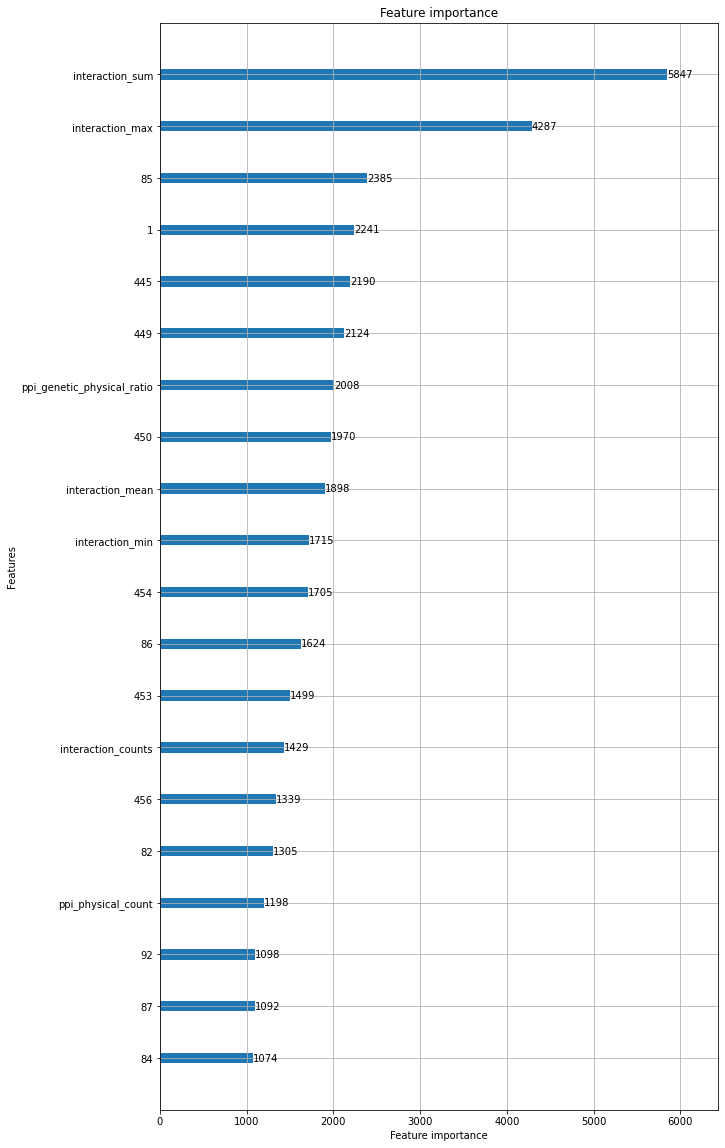

In [18]:
lgb.plot_importance(full_model, figsize=(10, 20), max_num_features=20);

In [19]:
important_feats = np.array(full_model.feature_name_)[full_model.feature_importances_ > 0]
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
important_feats = [int(feat) if RepresentsInt(feat) else feat for feat in important_feats]

## Reduced Feature Set

In [20]:
X_reduced = X[important_feats]
X_kaggle_reduced = X_kaggle[important_feats]
X_reduced.shape, X_kaggle_reduced.shape

((862, 137), (381, 137))

In [21]:
hyper_params['n_estimators'] = 400
hyper_params['learning_rate'] = 0.005

reduced_model = lgb.LGBMClassifier()
reduced_model.set_params(**hyper_params)
full_fit_params={
    "early_stopping_rounds": 10, 
    "eval_metric" : [
        f1_macro,
        balanced_accuracy,
        accuracy
    ],
    "eval_set" : [(X_reduced, y)],
    'eval_names': ['train'],
    'verbose': hyper_params['n_estimators'] // 10,
    
}
reduced_model.fit(X_reduced, y, **full_fit_params)

Training until validation scores don't improve for 10 rounds
[40]	train's f1: 0.0630374	train's bal. acc.: 0.0798611	train's acc.: 0.468677
[80]	train's f1: 0.269156	train's bal. acc.: 0.214054	train's acc.: 0.609049
[120]	train's f1: 0.547338	train's bal. acc.: 0.475121	train's acc.: 0.75406
[160]	train's f1: 0.618375	train's bal. acc.: 0.54761	train's acc.: 0.807425
[200]	train's f1: 0.756559	train's bal. acc.: 0.704479	train's acc.: 0.848028
[240]	train's f1: 0.833417	train's bal. acc.: 0.787318	train's acc.: 0.865429
[280]	train's f1: 0.84575	train's bal. acc.: 0.805155	train's acc.: 0.88051
[320]	train's f1: 0.919713	train's bal. acc.: 0.881958	train's acc.: 0.895592
[360]	train's f1: 0.901443	train's bal. acc.: 0.888345	train's acc.: 0.904872
[400]	train's f1: 0.914657	train's bal. acc.: 0.910121	train's acc.: 0.912993
Did not meet early stopping. Best iteration is:
[331]	train's f1: 0.920277	train's bal. acc.: 0.882652	train's acc.: 0.897912
Evaluated only: f1


LGBMClassifier(colsample_bytree=0.7, first_metric_only=True,
               learning_rate=0.005, max_depth=6, metric='None',
               min_child_samples=2, n_estimators=400, num_leaves=70,
               objective='multiclass', random_state=42, reg_alpha=0,
               reg_lambda=0.1, subsample=0.8)

# Competition Data

### Create Submission

In [22]:
y_kaggle = pd.Series(reduced_model.predict(X_kaggle[important_feats]))
pd.concat((y_kaggle.value_counts().sort_index(), y_kaggle.value_counts().sort_index() / len(y_kaggle)), axis=1)

,0,1
0,201,0.527559
1,122,0.320210
2,9,0.023622
3,24,0.062992
4,3,0.007874
5,13,0.034121
6,5,0.013123
7,2,0.005249
8,2,0.005249


In [23]:
# Compare with class distribution of training set
pd.concat((y.value_counts().sort_index(), y.value_counts().sort_index() / len(y)), axis=1)

,2960,2960
0,366,0.424594
1,192,0.222738
2,69,0.080046
3,58,0.067285
4,43,0.049884
5,43,0.049884
6,35,0.040603
7,18,0.020882
8,17,0.019722
9,10,0.011601


In [24]:
# Now create the kaggle submission file
submission = pd.concat((testdf[0], y_kaggle), axis=1)
submission.columns = ['Key', 'Label']
submission = submission.sort_values('Key').reset_index(drop=True)
submission.head()

,Key,Label
0,P234062,2
1,P234081,0
2,P234086,1
3,P234087,0
4,P234094,0


In [25]:
assert set(submission['Key']) == set(testdf[0])

In [26]:
timestamp = datetime.today().strftime('%Y_%m_%d-%H.%M')
submission_fname = f"submission-{timestamp}.csv"
submission.to_csv(submission_fname, index=False, header=True)
submission_fname

'submission-2021_04_01-01.22.csv'